In [13]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset


class HistopathologicCancerDataset(Dataset):
    """
    Histopathologic Cancer Detection dataset class compatible with PyTorch.
    
    This dataset contains 96x96 pixel histopathologic images for binary 
    classification (0 = no cancer, 1 = metastatic cancer tissue present).

    Parameters
    ----------
    root_dir : str
        Root directory containing the dataset (should contain 'train' and/or 'test' folders).
    data_type : str, default='train'
        Type of dataset to load. Must be 'train' or 'test'.
    transform : callable, optional
        A function/transform to apply to each image (e.g., torchvision.transforms).
    labels_file : str, optional
        Path to the CSV file containing labels. Required if data_type='train'.
        Should have columns: 'id' (image filename without extension) and 'label' (0 or 1).

    Attributes
    ----------
    data_dir : str
        Path to the image directory (train or test).
    image_ids : list
        List of image IDs (filenames without extensions).
    labels : dict or None
        Dictionary mapping image IDs to labels (only for training data).
    transform : callable
        Transform to apply to images.

    Methods
    -------
    __len__()
        Returns the number of samples in the dataset.
    __getitem__(idx)
        Returns the image and label at the given index, applying the transform if specified.
    visualize(img, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        Display a single image (tensor or NumPy array), un-normalizing if needed.
    get_class_distribution()
        Returns the distribution of classes in the dataset (only for training data).
    """
    
    def __init__(self, root_dir, data_type='train', transform=None, labels_file=None):
        """
        Initialize the dataset.
        
        Parameters
        ----------
        root_dir : str
            Root directory containing 'train' and/or 'test' folders
        data_type : str
            'train' or 'test'
        transform : callable, optional
            Transform to apply to images
        labels_file : str, optional
            Path to CSV file with labels (required for train)
        """
        self.root_dir = root_dir
        self.data_type = data_type
        self.transform = transform
        
        # Set the data directory based on type
        if data_type == 'train':
            self.data_dir = os.path.join(root_dir, 'train')
            
            # Load labels from CSV file
            if labels_file is None:
                # Try default location
                labels_file = os.path.join(root_dir, 'train_labels.csv')
            
            if not os.path.exists(labels_file):
                raise FileNotFoundError(
                    f"Labels file not found at {labels_file}. "
                    "Please provide the path to train_labels.csv"
                )
            
            # Read labels CSV
            labels_df = pd.read_csv(labels_file)
            
            # Create a dictionary mapping image_id to label
            self.labels = dict(zip(labels_df['id'], labels_df['label']))
            
            # Get list of image IDs from the labels file
            self.image_ids = list(self.labels.keys())
            
        elif data_type == 'test':
            self.data_dir = os.path.join(root_dir, 'test')
            self.labels = None
            
            # Get list of all image files in test directory
            self.image_ids = [
                f.replace('.tif', '') for f in os.listdir(self.data_dir) 
                if f.endswith('.tif')
            ]
            
        else:
            raise ValueError("data_type must be 'train' or 'test'")
        
        # Verify that the data directory exists
        if not os.path.exists(self.data_dir):
            raise FileNotFoundError(
                f"Data directory not found at {self.data_dir}. "
                f"Please ensure the dataset is properly extracted."
            )
    
    def __len__(self):
        """Return the total number of images in the dataset."""
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        """
        Get a single sample from the dataset.
        
        Parameters
        ----------
        idx : int
            Index of the sample to retrieve
            
        Returns
        -------
        tuple
            (image, label) where image is a PIL Image or transformed tensor,
            and label is an integer (0 or 1) for train data, or the image_id for test data
        """
        # Get image ID
        img_id = self.image_ids[idx]
        
        # Construct image path - images are .tif format
        img_path = os.path.join(self.data_dir, f"{img_id}.tif")
        
        # Load image using PIL
        img = Image.open(img_path).convert('RGB')
        
        # Apply transform if specified
        if self.transform:
            img = self.transform(img)
        
        # Return image and label (for train) or image_id (for test)
        if self.data_type == 'train':
            label = self.labels[img_id]
            return img, label
        else:
            # For test data, return the image_id instead of a label
            return img, img_id
    
    def visualize(self, img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
        """
        Display a single image (tensor or NumPy array), denormalizing if needed.
        
        Parameters
        ----------
        img : torch.Tensor or np.ndarray or PIL.Image
            Image to visualize
        mean : tuple
            Mean values used for normalization
        std : tuple
            Standard deviation values used for normalization
        """
        if isinstance(img, torch.Tensor):
            # Convert tensor to NumPy
            npimg = img.cpu().numpy()
            
            # Check if tensor is CHW (3,H,W), then permute to HWC
            if npimg.shape[0] == 3 and len(npimg.shape) == 3:
                npimg = np.transpose(npimg, (1, 2, 0))  # CHW -> HWC
            
            # Denormalize
            mean_arr = np.array(mean).reshape(1, 1, 3)
            std_arr = np.array(std).reshape(1, 1, 3)
            npimg = npimg * std_arr + mean_arr
            npimg = np.clip(npimg, 0, 1)
            
            plt.imshow(npimg)
        elif isinstance(img, Image.Image):
            # PIL Image
            plt.imshow(img)
        else:
            # NumPy array, assume already HWC
            plt.imshow(img)
        
        plt.axis('off')
        plt.show()
    
    def get_class_distribution(self):
        """
        Get the distribution of classes in the dataset.
        Only available for training data.
        
        Returns
        -------
        dict
            Dictionary with class counts: {0: count_no_cancer, 1: count_cancer}
        """
        if self.data_type != 'train' or self.labels is None:
            raise ValueError("Class distribution only available for training data")
        
        label_values = list(self.labels.values())
        distribution = {
            0: label_values.count(0),
            1: label_values.count(1)
        }
        
        print(f"Class Distribution:")
        print(f"  No Cancer (0): {distribution[0]:,} images ({distribution[0]/len(label_values)*100:.2f}%)")
        print(f"  Cancer (1): {distribution[1]:,} images ({distribution[1]/len(label_values)*100:.2f}%)")
        
        return distribution

In [14]:
from torchvision import transforms

# Define your transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the dataset
train_dataset = HistopathologicCancerDataset(
    root_dir='./data',
    data_type='train',
    transform=transform,
    labels_file='./data/train_labels.csv'
)

print(f"Dataset size: {len(train_dataset)}")
train_dataset.get_class_distribution()

Dataset size: 220025
Class Distribution:
  No Cancer (0): 130,908 images (59.50%)
  Cancer (1): 89,117 images (40.50%)


{0: 130908, 1: 89117}

# Data Vizualization

In [15]:
from PIL import Image, ImageDraw
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

In [16]:
# ============================================================================
# 1. LOAD AND EXPLORE THE LABELS
# ============================================================================

# Load the labels CSV
labels_df = pd.read_csv('./data/train_labels.csv')

print("=" * 70)
print("DATASET OVERVIEW")
print("=" * 70)
print("\nFirst 5 rows of the dataset:")
print(labels_df.head())

print("\n" + "=" * 70)
print("BASIC STATISTICS")
print("=" * 70)
print(f"\nTotal number of images: {len(labels_df):,}")
print(f"Number of unique IDs: {labels_df['id'].nunique():,}")

DATASET OVERVIEW

First 5 rows of the dataset:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

BASIC STATISTICS

Total number of images: 220,025
Number of unique IDs: 220,025


In [17]:
# ============================================================================
# 2. CHECK FOR DUPLICATES
# ============================================================================

print("\n" + "=" * 70)
print("DUPLICATE CHECK")
print("=" * 70)
duplicates = labels_df[labels_df.duplicated(keep=False)]
if len(duplicates) > 0:
    print(f"⚠️  Found {len(duplicates)} duplicate entries:")
    print(duplicates)
else:
    print("✓ No duplicate IDs found")


DUPLICATE CHECK
✓ No duplicate IDs found



CLASS DISTRIBUTION
label
0    130908
1     89117
Name: count, dtype: int64

Class 0 (No Cancer): 130,908 images (59.50%)
Class 1 (Cancer): 89,117 images (40.50%)


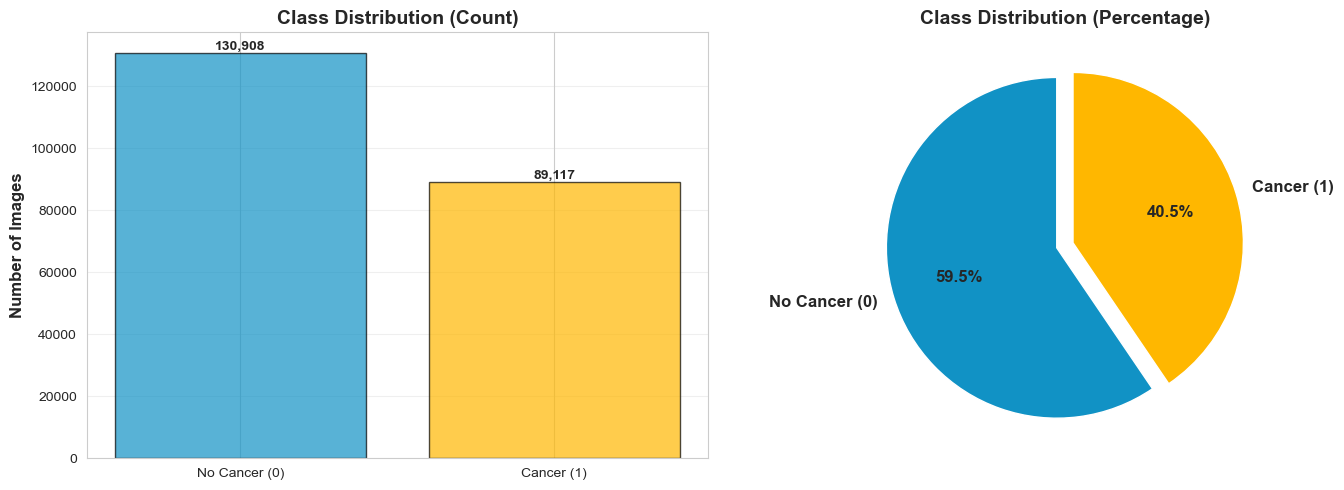

In [18]:
# ============================================================================
# 3. CLASS DISTRIBUTION
# ============================================================================

print("\n" + "=" * 70)
print("CLASS DISTRIBUTION")
print("=" * 70)
class_counts = labels_df['label'].value_counts().sort_index()
print(class_counts)
print(f"\nClass 0 (No Cancer): {class_counts[0]:,} images ({class_counts[0]/len(labels_df)*100:.2f}%)")
print(f"Class 1 (Cancer): {class_counts[1]:,} images ({class_counts[1]/len(labels_df)*100:.2f}%)")

# Plot class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(['No Cancer (0)', 'Cancer (1)'], class_counts.values, 
            color=["#1192c5", "#ffb700"], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Number of Images', fontsize=12, fontweight='bold')
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 1000, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
colors = ["#1192c5", "#ffb700"]
explode = (0.05, 0.05)
axes[1].pie(class_counts.values, labels=['No Cancer (0)', 'Cancer (1)'], 
            autopct='%1.1f%%', startangle=90, colors=colors, explode=explode,
            textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [19]:
# ============================================================================
# 4. GET IMAGE IDs BY CLASS
# ============================================================================

imgpath = "./data/train/"  # training data is stored in this folder
malignant = labels_df.loc[labels_df['label'] == 1]['id'].values  # cancer cases
normal = labels_df.loc[labels_df['label'] == 0]['id'].values     # normal cases

print("\n" + "=" * 70)
print("SAMPLE IMAGE IDs")
print("=" * 70)
print('Normal (No Cancer) IDs (first 3):')
print(normal[0:3])

print('\nMalignant (Cancer) IDs (first 3):')
print(malignant[0:3])


SAMPLE IMAGE IDs
Normal (No Cancer) IDs (first 3):
['f38a6374c348f90b587e046aac6079959adf3835'
 '755db6279dae599ebb4d39a9123cce439965282d'
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08']

Malignant (Cancer) IDs (first 3):
['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f']


In [28]:
# ============================================================================
# 5. VISUALIZATION FUNCTION
# ============================================================================

def plot_fig(ids, title, nrows=5, ncols=15, add_border=True):
    fig, ax = plt.subplots(nrows, ncols, figsize=(18, 6))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    for i, img_id in enumerate(ids[:nrows * ncols]):
        fname = os.path.join(imgpath, img_id + '.tif')
        
        try:
            img = Image.open(fname)
            
            # Add white border for visibility (optional)
            if add_border:
                idcol = ImageDraw.Draw(img)
                idcol.rectangle(((0, 0), (95, 95)), outline='white', width=2)
            
            # Plot the image
            row = i // ncols
            col = i % ncols
            
            if nrows == 1:
                axes = ax[col]
            else:
                axes = ax[row, col]
            
            axes.imshow(np.array(img))
            axes.axis('off')
            
        except Exception as e:
            print(f"Error loading image {img_id}: {e}")
    
    plt.suptitle(title, y=0.98, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


VISUALIZING SAMPLE IMAGES

Plotting malignant (cancer) cases...


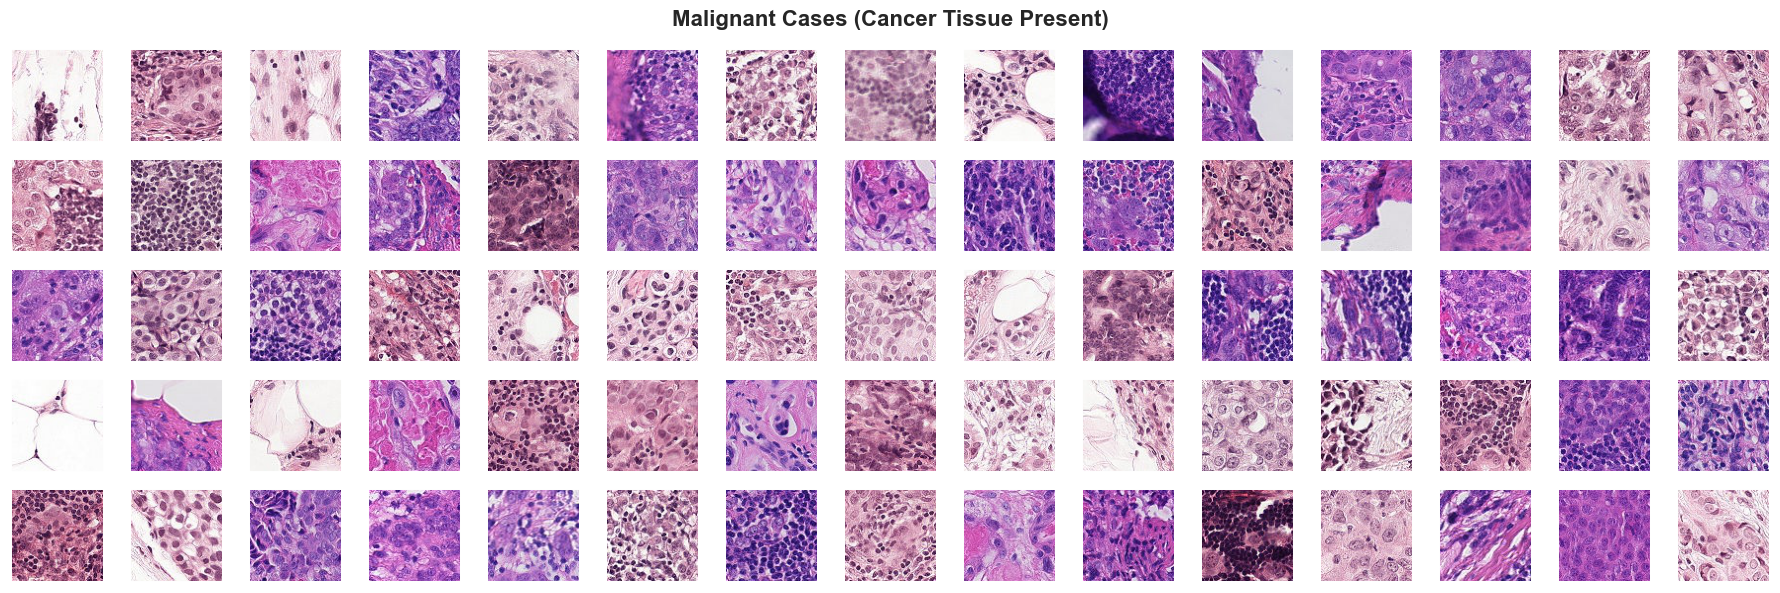

Plotting normal (no cancer) cases...


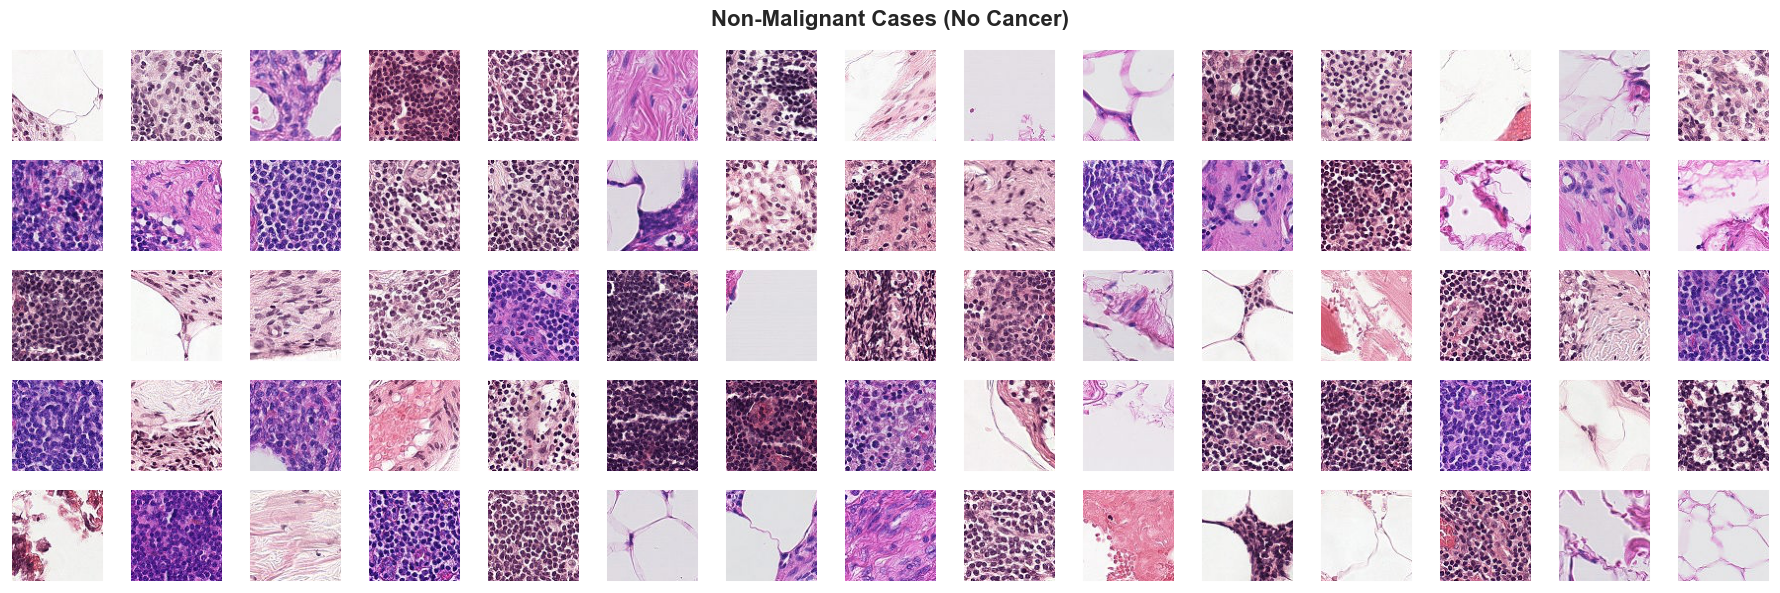

In [29]:
# ============================================================================
# 6. VISUALIZE SAMPLE IMAGES
# ============================================================================

print("\n" + "=" * 70)
print("VISUALIZING SAMPLE IMAGES")
print("=" * 70)

# Plot malignant cases
print("\nPlotting malignant (cancer) cases...")
plot_fig(malignant, 'Malignant Cases (Cancer Tissue Present)', nrows=5, ncols=15)

# Plot normal cases
print("Plotting normal (no cancer) cases...")
plot_fig(normal, 'Non-Malignant Cases (No Cancer)', nrows=5, ncols=15)


Creating side-by-side comparison...


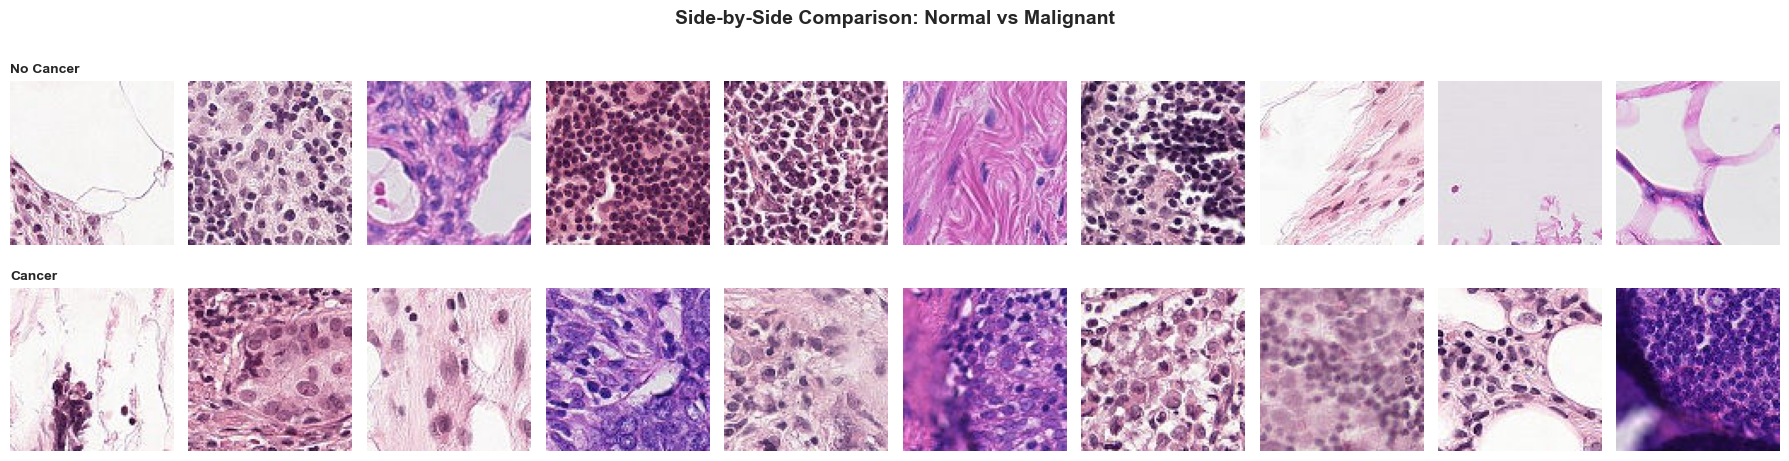

In [32]:
# ============================================================================
# 7. SIDE-BY-SIDE COMPARISON
# ============================================================================

print("\nCreating side-by-side comparison...")

def plot_comparison(normal_ids, malignant_ids, n_samples=10):
    """
    Plot normal and malignant images side by side for comparison.
    
    Parameters
    ----------
    normal_ids : array-like
        IDs of normal images
    malignant_ids : array-like
        IDs of malignant images
    n_samples : int
        Number of samples to display for each class
    """
    fig, axes = plt.subplots(2, n_samples, figsize=(18, 5))
    
    # Plot normal cases
    for i in range(n_samples):
        fname = os.path.join(imgpath, normal_ids[i] + '.tif')
        img = Image.open(fname)
        axes[0, i].imshow(np.array(img))
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('No Cancer', fontsize=10, fontweight='bold', loc='left')
    
    # Plot malignant cases
    for i in range(n_samples):
        fname = os.path.join(imgpath, malignant_ids[i] + '.tif')
        img = Image.open(fname)
        axes[1, i].imshow(np.array(img))
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Cancer', fontsize=10, fontweight='bold', loc='left')
    
    plt.suptitle('Side-by-Side Comparison: Normal vs Malignant', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

plot_comparison(normal, malignant, n_samples=10)